In [ ]:
!pip install q keras==2.3.1
!pip install q tensorflow==2.2.0

     |████████████████████████████████| 378kB 9.7MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 516.2MB 31kB/s 
     |████████████████████████████████| 460kB 64.8MB/s 
     |████████████████████████████████| 3.0MB 33.5MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [ ]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
 
import itertools
import datetime
import json
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, model_from_json
from keras.layers import Input, Embedding, LSTM, Lambda, Dropout
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adadelta
import tensorflow as tf


Using TensorFlow backend.


In [ ]:
import gensim

In [ ]:
pd.__version__

'1.1.4'

In [ ]:
#LoadData
class LoadData:
  def load_train_dataset(self,loc):
    data_df = pd.read_csv(loc, encoding='ISO-8859-1')
    return data_df

  def load_validation_dataset(self,loc):
    data_df = pd.read_csv(loc, encoding='ISO-8859-1')
    return data_df
  
  def load_test_dataset(self,loc):
    data_df = pd.read_csv(loc, encoding='ISO-8859-1')
    return data_df
#EndLoadData

In [ ]:
class Preproses:
  import json
  from json import load
  # Opening vocabulary JSON file 
  with open('/content/drive/My Drive/Colab Notebooks/vocab_scoring/vocabulary_scoring.json') as json_file: 
    vocabulary = load(json_file)

  # Opening inverse vocabulary file
  with open('/content/drive/My Drive/Colab Notebooks/vocab_scoring/inverse_vocabulary_scoring.txt', 'r') as f:
    inverse_vocabulary = json.loads(f.read())

  word2vec = Word2Vec.load('/content/drive/My Drive/Colab Notebooks/vector/w2vec_wiki_id_300_2')

  def preprocessing(self, data_df):
    indonesia_stop_words = [
    'yang', 'ada', 'berikut',
     'ini', 'untuk', 'apa',
     'berbagai', 'tetapi', 'maupun',
     'atas', 'berarti', 'itu',
     'apakah', 'demikian', 'bagaikan',
     'adalah', 'ialah', 'oleh', 'dsb', 'dll', 'dkk'
    ]
    def remove_indonesia_stopwords(data_df):
      return ' '.join([word for word in str(data_df).lower().split() if word not in indonesia_stop_words])

    data_df['jawaban_siswa']=data_df['jawaban_siswa'].str.lower()
    data_df['kunci_jawaban']=data_df['kunci_jawaban'].str.lower()

    # Remove tanda baca
    data_df['jawaban_siswa'] = data_df['jawaban_siswa'].str.replace('[^\w\s]', ' ')
    data_df['kunci_jawaban'] = data_df['kunci_jawaban'].str.replace('[^\w\s]', ' ')

    # Remove Indonesia stop words
    data_df.jawaban_siswa = data_df.jawaban_siswa.apply(remove_indonesia_stopwords)
    data_df.kunci_jawaban = data_df.kunci_jawaban.apply(remove_indonesia_stopwords)

    return data_df

  def text_to_number(self,data_df):
    def text_to_word_list(text):
      ''' Pre process and convert texts to a list of words '''
      text = str(text)
      text = text.split()
      return text
    
    vocabulary = self.vocabulary
    inverse_vocabulary = self.inverse_vocabulary
    word2vec = self.word2vec

    kalimat_cols = ['jawaban_siswa', 'kunci_jawaban']

    outside_words = set()

    # Iterate over the questions only of both training and test datasets
    for dataset in [data_df]:
      for index, row in dataset.iterrows():
        # Iterate through the text of both questions of the row
        for kalimat in kalimat_cols:
          kata_n_representasi = []  # kata representation

          for word in text_to_word_list(row[kalimat]):
            # mendadtarkan kata yang tidak ada pada word2vec
            if word not in word2vec.wv.vocab:
              outside_words.add(word)

            if word not in vocabulary:
              vocabulary[word] = len(inverse_vocabulary)
              kata_n_representasi.append(len(inverse_vocabulary))
              inverse_vocabulary.append(word)
            else:
              kata_n_representasi.append(vocabulary[word])

            # Replace word to number representation
            dataset.at[index, kalimat] = kata_n_representasi
    
    import json
    json = json.dumps(vocabulary)
    f = open("vocabulary.json","w")
    f.write(json)
    f.close()

    import json as j
    with open('inverse_vocabulary.txt', 'w') as f:
        f.write(j.dumps(inverse_vocabulary))
    
    self.outside = outside_words

    return data_df

  def embedding_matrix(self):
    vocabulary = self.vocabulary
    word2vec = self.word2vec
    embedding_dim = 300
    embeddings = 1 * np.random.randn(len(vocabulary)+1, embedding_dim)  # Embedding matrix
    embeddings[0] = 0  # mengabaikan padding

    # Membangun embedding matrix
    for word, index in vocabulary.items():
        if word in word2vec.wv.vocab:
            embeddings[index] = word2vec.wv[word]

    del word2vec
    return embeddings
  
  def zero_padding(self,data_df):
    max_seq_length = 100
    data_df = {'left': data_df.jawaban_siswa, 'right': data_df.kunci_jawaban}
    
    for dataset, side in itertools.product([data_df],['left','right']):
      dataset[side] = pad_sequences(dataset[side], maxlen = max_seq_length)

    return data_df

In [ ]:
class Train:

  def parameter(self, batchsize=64, nhidden=30, epo=25):
    self.batchsize = batchsize
    self.nhidden = nhidden
    self.epo = epo
    
  
  def training(self, X_train, Y_train, X_validation, Y_validation, prep):
    tf.keras.backend.clear_session()
    tf.random.set_seed(3)
    np.random.seed(3)
    self.embed = prep.embedding_matrix()
    gradient_clipping_norm = 1.25 
    embedding_dim = 300
    max_seq_length = 100

    # def exponent_neg_manhattan_distance(left, right):
    #   ''' Helper function for the similarity estimate of the LSTMs outputs'''
    #   return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

    # Set 2 input
    left_input = Input(shape=(max_seq_length,), dtype='int32')
    right_input = Input(shape=(max_seq_length,), dtype='int32')

    embedding_layer = Embedding(len(self.embed), embedding_dim, weights=[self.embed], input_length=max_seq_length, trainable=False)

    # Embedded version of the inputs
    encoded_left = embedding_layer(left_input)
    encoded_right = embedding_layer(right_input)

    # Since this is a siamese network, both sides share the same LSTM
    shared_lstm = LSTM(self.nhidden)

    left_output = shared_lstm(encoded_left)
    right_output = shared_lstm(encoded_right)

    # dropout_layer = Dropout(0.2)

    # left_output = dropout_layer(left_lstm)
    # right_output = dropout_layer(right_lstm)

    # Calculates the distance as defined by the MaLSTM model
    malstm_distance = Lambda(function=lambda x: K.exp(-K.sum(K.abs(x[0]-x[1]), axis=1, keepdims=True)),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

    # Pack it all up into a model
    self.model = Model([left_input, right_input], [malstm_distance])

    # Adadelta optimizer, with gradient clipping by norm
    optimizer = Adadelta(clipnorm=gradient_clipping_norm)

    self.model.compile(loss='mean_squared_error', optimizer=optimizer)

    # Start training
    training_start_time = time()

    self.malstm_trained = self.model.fit([X_train['left'], X_train['right']], Y_train, batch_size=self.batchsize, epochs=self.epo,
                                validation_data=([X_validation['left'], X_validation['right']], Y_validation))# callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

    print("Training time finished.\n{} epochs in {}".format(self.epo, datetime.timedelta(seconds=time()-training_start_time)))
    return self.model

  def save_model(self, model):
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
      json_file.write(model_json)
    model.save_weights('weights.h5')
    return "Model tersimpan."


In [ ]:
class Testing:

  def set_model(self,train):
    json_file = open("model.json", "r")
    loaded_model_json = json_file.read()
    json_file.close()

    train.model = model_from_json(loaded_model_json)
    train.model.load_weights("weights.h5")
    train.model_loaded = True
  
  def testing(self,data_df,prep,train):
    from copy import copy
    self.data_df = data_df
    self.prediksi_df = copy(data_df)
    datatest_df = data_df
    datatest_df = prep.preprocessing(datatest_df)
    datatest_df = prep.text_to_number(datatest_df)
    datatest_df = prep.zero_padding(datatest_df)

    hasil_test = train.model.predict([datatest_df['left'],datatest_df['right']])

    self.prediksi_df['prediction'] = hasil_test
    loc = 'hasil_prediksi.csv'
    hasil_test_df = self.prediksi_df
    hasil_test_df.to_csv(loc, index=False)

    return hasil_test_df

In [ ]:
class Plot:
  def plot(self, a, b, judul, label_a, label_b, label_y, label_x, keterangan):
    import datetime as dtm
    #plt.figure(figsize=(9,5))
    plt.plot(a, label=label_a, lw=2)
    plt.plot(b, label=label_b, lw=2)
    plt.title(judul)
    plt.ylabel(label_y)
    plt.xlabel(label_x)
    plt.legend()
    self.t = dtm.datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
    self.nm = keterangan + self.t + '.png'
    plt.savefig(self.nm)
    plt.show()
    plt.close()
    return self.nm

In [ ]:
load = LoadData()
prep = Preproses()
plot = Plot()
trn = Train()

In [ ]:
train = load.load_train_dataset('/content/drive/My Drive/Colab Notebooks/vocab_scoring/train_skoring.csv')

In [ ]:
validation = load.load_validation_dataset('/content/drive/My Drive/Colab Notebooks/vocab_scoring/validation_skoring.csv')

In [ ]:
train_df = prep.preprocessing(train)

In [ ]:
validation_df = prep.preprocessing(validation)

In [ ]:
train_df = prep.text_to_number(train_df)

In [ ]:
outside_latih = prep.outside

In [ ]:
len(outside_latih)

179

In [ ]:
validation_df = prep.text_to_number(validation_df)

In [ ]:
len(prep.outside)

55

In [ ]:
kalimat_cols = ['jawaban_siswa', 'kunci_jawaban']

In [ ]:
X_train = train_df[kalimat_cols]
Y_train = train_df['value']
X_validation = validation_df[kalimat_cols]
Y_validation = validation_df['value']

In [ ]:
# kalimat_cols = ['jawaban_siswa', 'kunci_jawaban']
# num_samples = len(train_df)
# validation_size = (int)(num_samples * 0.2)
# training_size = len(train_df) - validation_size

# X = train_df[kalimat_cols]
# Y = train_df['value']

# X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

In [ ]:
X_train = prep.zero_padding(X_train)

In [ ]:
X_validation = prep.zero_padding(X_validation)

In [ ]:
X_train['left'][0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,  285,  404,  473,  123,  842,  201,
        141, 2738,  124,  892, 1384,   18,   42,  123, 2739,    5, 1021,
       2739], dtype=int32)

In [ ]:
trn.parameter(32,20,15)

In [ ]:
model = trn.training(X_train, Y_train, X_validation, Y_validation, prep)

Train on 7353 samples, validate on 1839 samples
Epoch 1/15
7353/7353 [==============================] - 21s 3ms/step - loss: 0.1057 - val_loss: 0.0840
Epoch 2/15
7353/7353 [==============================] - 22s 3ms/step - loss: 0.0825 - val_loss: 0.0752
Epoch 3/15
7353/7353 [==============================] - 20s 3ms/step - loss: 0.0740 - val_loss: 0.0705
Epoch 4/15
7353/7353 [==============================] - 20s 3ms/step - loss: 0.0688 - val_loss: 0.0682
Epoch 5/15
7353/7353 [==============================] - 20s 3ms/step - loss: 0.0655 - val_loss: 0.0663
Epoch 6/15
7353/7353 [==============================] - 20s 3ms/step - loss: 0.0630 - val_loss: 0.0645
Epoch 7/15
7353/7353 [==============================] - 20s 3ms/step - loss: 0.0613 - val_loss: 0.0634
Epoch 8/15
7353/7353 [==============================] - 24s 3ms/step - loss: 0.0596 - val_loss: 0.0625
Epoch 9/15
7353/7353 [==============================] - 21s 3ms/step - loss: 0.0584 - val_loss: 0.0623
Epoch 10/15
7353/7353 [==

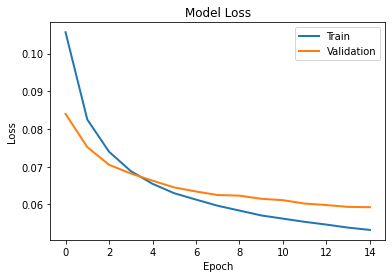

In [ ]:
loss_plot = plot.plot(trn.malstm_trained.history['loss'],trn.malstm_trained.history['val_loss'],'Model Loss','Train','Validation','Loss','Epoch','model_loss')

In [ ]:
model_simpan = trn.save_model(trn.model)

In [ ]:
test_dataset = load.load_test_dataset('/content/drive/My Drive/Colab Notebooks/vocab_scoring/test_skoring.csv')

In [ ]:
test_dataset

,nama,jawaban_siswa,kunci_jawaban,value
0,Jack,"seperangkat asas-asas hukum, aturan-aturan huk...",peraturan yang mengatur perilaku masyarakat be...,0.0
1,Feby,tanggung jawab lancar yang kepastian jumlah ya...,suatu hal yang harus dilakukan oleh seseorang,0.3
2,Bella Fransiska,Pengiriman dan mengeluarkan barang dari dalam ...,kegiatan menjual atau mengeluarkan barang dari...,0.8
3,Seri Mita Mutiara,Rotasi Bumi merujuk pada gerakan berputar plan...,gerakan perputaran bumi pada poros atau sumbunya,1.0
4,Tazrian Husna,perpindahan penduduk dari daerah yang padat pe...,perpindahan penduduk dari daerah yang padat pe...,1.0
...,...,...,...,...
2293,Tria Riskiani,"interaksi yang terjadi pada dua makhluk hidup,...",hubungan antara dua makhluk hidup yang mengunt...,0.4
2294,Tim Tampubolon,perpindahan penduduk dengan tujuan untuk Mempe...,perpindahan penduduk dari desa ke kota,0.0
2295,MPS,salah satu alat bantu yang dapat dipergunakan ...,alat navigasi untuk menunjukkan arah mata angin.,0.7
2296,Lucas,suatu usaha untuk perubahan yang diperlihatkan...,suatu proses usaha yang dilakukan seseorang un...,0.7


In [ ]:
from copy import copy
test_df = copy(test_dataset)

In [ ]:
testing = Testing()

In [ ]:
testing.set_model(trn)

In [ ]:
hasil = testing.testing(test_df, prep, trn)

In [ ]:
prep.outside

{'3',
 'barangatau',
 'dilakukandari',
 'i',
 'inshaf',
 'keasusilaan',
 'kemagnetisannya',
 'kenegarannya',
 'kerahasiannya',
 'keseberagaman',
 'ketergangguan',
 'komensalime',
 'lalukan',
 'llingkungannya',
 'mahkuk',
 'masalalu',
 'megurus',
 'memabac',
 'membagai',
 'membutuhkanya',
 'memperleh',
 'mempertegak',
 'mempertimbangkan',
 'mempresentasikan',
 'menawarkanatau',
 'mendistribusikan',
 'menempe',
 'mengagaskan',
 'menggelembungkan',
 'menghayatinya',
 'menginventarisasi',
 'mengkomunikasikan',
 'mengkoordinasikan',
 'menguntungan',
 'mensubtitusikan',
 'menyebarluaskannya',
 'menyelenggarkaan',
 'nonfarmasi',
 'onomata',
 'penergah',
 'penggerakkan',
 'pengikisian',
 'pengorganisasian',
 'perkemabangan',
 'persembatanan',
 'psikofisis',
 'rganisasi',
 'rhemata',
 'rugikan',
 'sebaguan',
 'sebangkunya',
 'sekap',
 'tepati',
 'tergorganisasi',
 'teritonal',
 'terkomputerisasi',
 'tertendang',
 'transkultural'}

In [ ]:
len(prep.outside)

58

In [ ]:
hasil

,nama,jawaban_siswa,kunci_jawaban,value,prediction
0,Jack,"seperangkat asas-asas hukum, aturan-aturan huk...",peraturan yang mengatur perilaku masyarakat be...,0.3,0.091855
1,Feby,tanggung jawab lancar yang kepastian jumlah ya...,suatu hal yang harus dilakukan oleh seseorang,0.3,0.287401
2,Bella Fransiska,Pengiriman dan mengeluarkan barang dari dalam ...,kegiatan menjual atau mengeluarkan barang dari...,0.8,0.816678
3,Seri Mita Mutiara,Rotasi Bumi merujuk pada gerakan berputar plan...,gerakan perputaran bumi pada poros atau sumbunya,1.0,0.818697
4,Tazrian Husna,perpindahan penduduk dari daerah yang padat pe...,perpindahan penduduk dari daerah yang padat pe...,1.0,1.000000
...,...,...,...,...,...
2293,Tria Riskiani,"interaksi yang terjadi pada dua makhluk hidup,...",hubungan antara dua makhluk hidup yang mengunt...,0.4,0.634415
2294,Tim Tampubolon,perpindahan penduduk dengan tujuan untuk Mempe...,perpindahan penduduk dari desa ke kota,0.0,0.271855
2295,MPS,salah satu alat bantu yang dapat dipergunakan ...,alat navigasi untuk menunjukkan arah mata angin.,0.7,0.634445
2296,Lucas,suatu usaha untuk perubahan yang diperlihatkan...,suatu proses usaha yang dilakukan seseorang un...,0.7,0.582240


In [ ]:
hasil['value'].corr(hasil['prediction'], method='pearson')

0.8511335218060531

In [ ]:
hasil['prediction'].corr(hasil['value'], method='spearman')

0.8676771304409602

In [ ]:
test_data = load.load_test_dataset('/content/drive/My Drive/Colab Notebooks/testing_dataset.csv')

In [ ]:
test_dataset = prep.preprocessing(test_data)
test_dataset = prep.text_to_number(test_dataset)

In [ ]:
X_test = test_dataset[kalimat_cols]
Y_test = test_dataset['value']

In [ ]:
X_test = prep.zero_padding(X_test)

In [ ]:
import math
train_score = model.evaluate([X_validation['left'], X_validation['right']], Y_validation)

1839/1839 [==============================] - 2s 984us/step


In [ ]:
train_score

0.07702136775068513

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     1812300     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 30)           39720       embedding_1[0][0]          

In [ ]:
hasil

,nama,jawaban_siswa,kunci_jawaban,value,prediction
0,Jack,"seperangkat asas-asas hukum, aturan-aturan huk...",peraturan yang mengatur perilaku masyarakat be...,0,0.243703
1,Feby,tanggung jawab lancar yang kepastian jumlah ya...,suatu hal yang harus dilakukan oleh seseorang,0,0.295670
2,Bella Fransiska,Pengiriman dan mengeluarkan barang dari dalam ...,kegiatan menjual atau mengeluarkan barang dari...,1,0.726219
3,Seri Mita Mutiara,Rotasi Bumi merujuk pada gerakan berputar plan...,gerakan perputaran bumi pada poros atau sumbunya,1,0.823386
4,Tazrian Husna,perpindahan penduduk dari daerah yang padat pe...,perpindahan penduduk dari daerah yang padat pe...,1,1.000000
...,...,...,...,...,...
2293,Tria Riskiani,"interaksi yang terjadi pada dua makhluk hidup,...",hubungan antara dua makhluk hidup yang mengunt...,0,0.376915
2294,Tim Tampubolon,perpindahan penduduk dengan tujuan untuk Mempe...,perpindahan penduduk dari desa ke kota,0,0.146524
2295,MPS,salah satu alat bantu yang dapat dipergunakan ...,alat navigasi untuk menunjukkan arah mata angin.,1,0.516152
2296,Lucas,suatu usaha untuk perubahan yang diperlihatkan...,suatu proses usaha yang dilakukan seseorang un...,1,0.633973
